# ML modelling เอาเฉพาะที่ดีที่สุดในแต่ละ ZR เน้นลด MFB hourly
* CAPPI 2 km vs the best ZR in MFB


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from scipy.stats import uniform, randint, linregress
import xgboost as xgb

import geopandas as gpd

warnings.filterwarnings('ignore')



## Read and cleansing data

In [2]:
df = pd.read_csv('./00Results/00rain_radar_hourly_extracted_all_events_mean_dBZ/df_org_dbz_rain_test120km.csv')
df.drop(df[df['rain_x'] <= 0].index, inplace = True) # ทดสอบการตัดฝนอ่อนตรงนี้้ได 0, 0.5,1.0
#df.drop(df[df['rain_x'] < 1.0].index, inplace = True) # ทดสอบการตัดฝนอ่อนตรงนี้้ได 0, 0.5,1.0
#df.drop(df[df['cappi1km'] < 10].index, inplace = True) #ฝนอ่่อนมากๆ < 10 dBZ
#df.drop(df[df['cappi4km'] > 55].index, inplace = True) #ค่าการสะท้อนที่อาจเป็นลูกเห็บ 55 dBZ มุมยกด้านบนสุด
df.drop(columns=['Unnamed: 0'], axis=1, inplace=True)
#df.reset_index(drop=True)
#df.dropna(inplace=True)

In [3]:
df.rename(columns={"cappi1km": "dBZ_c1", "cappi2km": "dBZ_c2","cappi3km": "dBZ_c3","cappi4km": "dBZ_c4"}, inplace=True)
df.rename(columns={"rain_x":"rain_truth"}, inplace=True)
df

,dBZ_c1,dBZ_c2,dBZ_c3,dBZ_c4,full_date,code,rain_truth
6,NaN,NaN,NaN,NaN,2018-06-01-00:00,CTKN,10.8
28,NaN,NaN,NaN,NaN,2018-06-01-00:00,NMPR,3.6
72,22.267728,22.656334,23.252944,23.492632,2018-06-01-01:00,CMSG,0.4
107,37.450751,35.934908,34.647741,31.643592,2018-06-01-01:00,PIN004,0.2
138,28.847841,28.025389,26.520176,24.078056,2018-06-01-02:00,CMSG,0.2
...,...,...,...,...,...,...,...
68305,NaN,NaN,NaN,NaN,2018-09-21-18:00,CNDN,0.4
68328,NaN,NaN,NaN,NaN,2018-09-21-18:00,NAN005,1.0
68334,18.423027,18.423027,18.423027,NaN,2018-09-21-18:00,NGBA,0.8
68411,29.833809,NaN,NaN,NaN,2018-09-21-19:00,NAN013,24.8


### คำนวณฝนประมาณค่าจากเรดาร์ค่าด้วย ZR Vectorized Operations:

In [4]:
#  Vectorized Operations:
constants = {
    'MP': (200, 1.6), # ZR marshall/palmer
    'RF': (250, 1.2), # ZR Rosenfeld
    'SC': (300, 1.4) # ZR Summer Deep Convection
}

for prefix, (a, b) in constants.items():
    for suffix in ['c1', 'c2', 'c3', 'c4']:
        dBZ_column = f'dBZ_{suffix}'
        rr_column = f'rr_{prefix}_{suffix}'
        df[rr_column] = ((10**(df[dBZ_column]/10.))/a)**(1/b)

In [5]:
#### ดรอปคอมลัมน์ cappi ทิ้ง
df.drop(columns=['dBZ_c1','dBZ_c2','dBZ_c3','dBZ_c4'], inplace=True) #ลบคอลัน์
df

,full_date,code,rain_truth,rr_MP_c1,rr_MP_c2,rr_MP_c3,rr_MP_c4,rr_RF_c1,rr_RF_c2,rr_RF_c3,rr_RF_c4,rr_SC_c1,rr_SC_c2,rr_SC_c3,rr_SC_c4
6,2018-06-01-00:00,CTKN,10.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28,2018-06-01-00:00,NMPR,3.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72,2018-06-01-01:00,CMSG,0.4,0.898647,0.950336,1.035536,1.071879,0.720047,0.775791,0.869885,0.910827,0.662491,0.706216,0.779027,0.810350
107,2018-06-01-01:00,PIN004,0.2,7.989658,6.423741,5.337527,3.464023,13.262108,9.914991,7.745125,4.351938,8.047877,6.272011,5.075354,3.096594
138,2018-06-01-02:00,CMSG,0.2,2.316575,2.057989,1.657171,1.166097,2.545092,2.173530,1.628288,1.019111,1.955185,1.707816,1.333294,0.892255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68305,2018-09-21-18:00,CNDN,0.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68328,2018-09-21-18:00,NAN005,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68334,2018-09-21-18:00,NGBA,0.8,0.516768,0.516768,0.516768,NaN,0.344325,0.344325,0.344325,NaN,0.352013,0.352013,0.352013,NaN
68411,2018-09-21-19:00,NAN013,24.8,2.669742,NaN,NaN,NaN,3.075158,NaN,NaN,NaN,2.299397,NaN,NaN,NaN


In [6]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [7]:
df

,full_date,code,rain_truth,rr_MP_c1,rr_MP_c2,rr_MP_c3,rr_MP_c4,rr_RF_c1,rr_RF_c2,rr_RF_c3,rr_RF_c4,rr_SC_c1,rr_SC_c2,rr_SC_c3,rr_SC_c4
0,2018-06-01-01:00,CMSG,0.4,0.898647,0.950336,1.035536,1.071879,0.720047,0.775791,0.869885,0.910827,0.662491,0.706216,0.779027,0.810350
1,2018-06-01-01:00,PIN004,0.2,7.989658,6.423741,5.337527,3.464023,13.262108,9.914991,7.745125,4.351938,8.047877,6.272011,5.075354,3.096594
2,2018-06-01-02:00,CMSG,0.2,2.316575,2.057989,1.657171,1.166097,2.545092,2.173530,1.628288,1.019111,1.955185,1.707816,1.333294,0.892255
3,2018-06-01-02:00,NSRS,2.8,26.740589,25.118143,21.500539,16.534742,66.395140,61.078967,49.641029,34.976114,32.009071,29.799314,24.947083,18.478841
4,2018-06-01-03:00,CMSG,0.2,5.971266,4.801238,4.734323,5.353180,8.994911,6.725314,6.600631,7.775424,5.769704,4.496865,4.425311,5.092368
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2601,2018-09-20-16:00,TGSK,0.8,0.871279,1.291773,1.794893,1.963920,0.690957,1.168127,1.811173,2.042083,0.639483,1.002976,1.460664,1.618897
2602,2018-09-20-17:00,PAS003,2.6,7.637749,6.846747,5.652252,4.423040,12.489034,10.794950,8.359949,6.028410,7.644055,6.746207,5.418789,4.094371
2603,2018-09-20-17:00,TGSK,0.2,0.816687,1.046085,1.194923,1.347858,0.633844,0.881721,1.052838,1.236234,0.593899,0.788103,0.917506,1.052896
2604,2018-09-21-14:00,PIN003,2.4,3.570917,3.593265,3.415970,2.660618,4.531911,4.569766,4.271631,3.061153,3.206039,3.228980,3.047550,2.290418


## Feature analysis

###  Correlation matrix analysis:

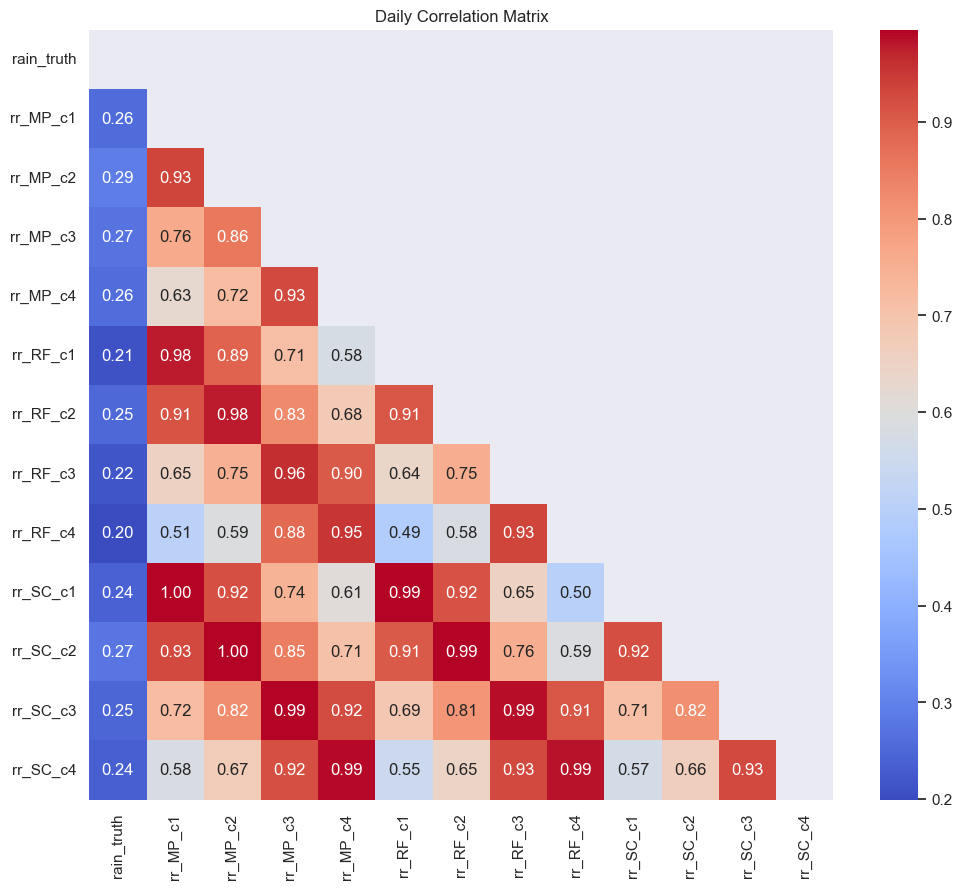

important_features_corr: ['rain_truth', 'rr_MP_c2', 'rr_SC_c2', 'rr_MP_c3', 'rr_MP_c4', 'rr_MP_c1', 'rr_RF_c2', 'rr_SC_c3', 'rr_SC_c1', 'rr_SC_c4', 'rr_RF_c3', 'rr_RF_c1']


In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df.corr()

# Create a mask for the lower triangular part
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set the font scale for the heatmap
sns.set(font_scale=1.0)  # Adjust the font scale as needed

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
plt.title("Daily Correlation Matrix")
plt.show()

# Identify features highly correlated with the target
correlation_with_target = correlation_matrix['rain_truth'].abs().sort_values(ascending=False)
important_features_corr = correlation_with_target[correlation_with_target > 0.20].index.tolist()
print('important_features_corr:', important_features_corr)


## ML GBR เหมาะใช้กับ ZR MP

### เตรียมข้อมูล

In [9]:
# แยกข้อมูล
from sklearn.model_selection import train_test_split
TargetVariable=['rain_truth']
#Predictors=['rr_RF_c1', 'dBZ_p1', 'rr_SC_c1', 'rr_RF_p1', 'dBZ_c1', 'rr_MP_c1']
#Predictors=['dBZ_c1', 'dBZ_c2', 'dBZ_c3', 'dBZ_c4']
Predictors=['rr_MP_c1', 'rr_MP_c2', 'rr_MP_c3', 'rr_MP_c4']

X=df[Predictors].values
y=df[TargetVariable].values

# Split data 70%-30% into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))

Training Set: 1824 rows
Test Set: 782 rows


### ใช้แบบจำลอง Use GBR algorithm

In [10]:
# Use a Gradient Boosting algorithm
alg = GradientBoostingRegressor()

# Define the hyperparameter search space
params = {
    'learning_rate': uniform(0.01, 1.0),
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Define RMSE as the scoring metric (negative MSE)
score = 'neg_mean_squared_error'
random_search = RandomizedSearchCV(alg, params, n_iter=50, scoring=score, cv=5, random_state=42, return_train_score=True)
random_search.fit(X_train, y_train)

print("Best parameter combination:", random_search.best_params_, "\n")

# Get the best model
best_model_GradientBoostingRegressor = random_search.best_estimator_
print(best_model_GradientBoostingRegressor, "\n")

# Evaluate the model using the test data
predictions_GradientBoostingRegressor = best_model_GradientBoostingRegressor.predict(X_test)

Best parameter combination: {'learning_rate': 0.12005192452767675, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 50, 'subsample': 0.8} 

GradientBoostingRegressor(learning_rate=0.12005192452767675, min_samples_leaf=4,
                          min_samples_split=5, n_estimators=50, subsample=0.8) 



In [11]:
before_adjust_MP=np.sum(y_test.flatten())/np.sum(X_test[:,1])
after_adjust_MP=np.sum(y_test.flatten())/np.sum(best_model_GradientBoostingRegressor.predict(X_test).flatten())

#std_before_adjust_MP=np.std(y_test.flatten()-X_test[:,1])
#std_after_adjust_MP=np.std(y_test.flatten()-best_model_GradientBoostingRegressor.predict(X_test).flatten())

std_before_adjust_MP=np.std(np.abs(y_test.flatten()-X_test[:,1]))
std_after_adjust_MP=np.std(np.abs(y_test.flatten()-best_model_GradientBoostingRegressor.predict(X_test).flatten()))

## ML GBR เหมาะสมใช้กับ ZR RF

### เตรียมข้อมูล

In [12]:
# แยกข้อมูล
from sklearn.model_selection import train_test_split
TargetVariable=['rain_truth']
#Predictors=['rr_RF_c1', 'dBZ_p1', 'rr_SC_c1', 'rr_RF_p1', 'dBZ_c1', 'rr_MP_c1']
#Predictors=['dBZ_c1', 'dBZ_c2', 'dBZ_c3', 'dBZ_c4']
Predictors=['rr_RF_c1', 'rr_RF_c2', 'rr_RF_c3', 'rr_RF_c4']

X=df[Predictors].values
y=df[TargetVariable].values

# Split data 70%-30% into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))

Training Set: 1824 rows
Test Set: 782 rows


### ใช้แบบจำลอง Use GBR algorithm

In [13]:
# Use a Gradient Boosting algorithm
alg = GradientBoostingRegressor()

# Define the hyperparameter search space
params = {
    'learning_rate': uniform(0.01, 1.0),
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Define RMSE as the scoring metric (negative MSE)
score = 'neg_mean_squared_error'
random_search = RandomizedSearchCV(alg, params, n_iter=50, scoring=score, cv=5, random_state=42, return_train_score=True)
random_search.fit(X_train, y_train)

print("Best parameter combination:", random_search.best_params_, "\n")

# Get the best model
best_model_GradientBoostingRegressor = random_search.best_estimator_
print(best_model_GradientBoostingRegressor, "\n")

# Evaluate the model using the test data
predictions_GradientBoostingRegressor = best_model_GradientBoostingRegressor.predict(X_test)

Best parameter combination: {'learning_rate': 0.12005192452767675, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 50, 'subsample': 0.8} 

GradientBoostingRegressor(learning_rate=0.12005192452767675, min_samples_leaf=4,
                          min_samples_split=5, n_estimators=50, subsample=0.8) 



In [14]:
before_adjust_RF=np.sum(y_test.flatten())/np.sum(X_test[:,1])
after_adjust_RF=np.sum(y_test.flatten())/np.sum(best_model_GradientBoostingRegressor.predict(X_test).flatten())

#std_before_adjust_RF=np.std(y_test.flatten()-X_test[:,1])
#std_after_adjust_RF=np.std(y_test.flatten()-best_model_GradientBoostingRegressor.predict(X_test).flatten())

std_before_adjust_RF=np.std(np.abs(y_test.flatten()-X_test[:,1]))
std_after_adjust_RF=np.std(np.abs(y_test.flatten()-best_model_GradientBoostingRegressor.predict(X_test).flatten()))

### ML GBR เหมาะสมใช้กับ ZR SC

### เตรียมข้อมูล

In [15]:
# แยกข้อมูล
from sklearn.model_selection import train_test_split
TargetVariable=['rain_truth']
#Predictors=['rr_RF_c1', 'dBZ_p1', 'rr_SC_c1', 'rr_RF_p1', 'dBZ_c1', 'rr_MP_c1']
#Predictors=['dBZ_c1', 'dBZ_c2', 'dBZ_c3', 'dBZ_c4']
Predictors=['rr_SC_c1', 'rr_SC_c2', 'rr_SC_c3', 'rr_SC_c4']

X=df[Predictors].values
y=df[TargetVariable].values

# Split data 70%-30% into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))

Training Set: 1824 rows
Test Set: 782 rows


### ใช้แบบจำลอง Use GBR algorithm

In [16]:
# Use a Gradient Boosting algorithm
alg = GradientBoostingRegressor()

# Define the hyperparameter search space
params = {
    'learning_rate': uniform(0.01, 1.0),
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Define RMSE as the scoring metric (negative MSE)
score = 'neg_mean_squared_error'
random_search = RandomizedSearchCV(alg, params, n_iter=50, scoring=score, cv=5, random_state=42, return_train_score=True)
random_search.fit(X_train, y_train)

print("Best parameter combination:", random_search.best_params_, "\n")

# Get the best model
best_model_GradientBoostingRegressor = random_search.best_estimator_
print(best_model_GradientBoostingRegressor, "\n")

# Evaluate the model using the test data
predictions_GradientBoostingRegressor = best_model_GradientBoostingRegressor.predict(X_test)

Best parameter combination: {'learning_rate': 0.12005192452767675, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 50, 'subsample': 0.8} 

GradientBoostingRegressor(learning_rate=0.12005192452767675, min_samples_leaf=4,
                          min_samples_split=5, n_estimators=50, subsample=0.8) 



In [17]:
before_adjust_SC=np.sum(y_test.flatten())/np.sum(X_test[:,1])
after_adjust_SC=np.sum(y_test.flatten())/np.sum(best_model_GradientBoostingRegressor.predict(X_test).flatten())

#std_before_adjust_SC=np.std(y_test.flatten()-X_test[:,1])
#std_after_adjust_SC=np.std(y_test.flatten()-best_model_GradientBoostingRegressor.predict(X_test).flatten())

std_before_adjust_SC=np.std(np.abs(y_test.flatten()-X_test[:,1]))
std_after_adjust_SC=np.std(np.abs(y_test.flatten()-best_model_GradientBoostingRegressor.predict(X_test).flatten()))

## พลอตกราฟแท่งเปรียบเทียบค่า MFB ก่อนและหลัง การทำนายด้วยแบบจำลองที่ดีที่สุด

In [18]:
print(before_adjust_MP)
print(after_adjust_MP)
print(before_adjust_RF)
print(after_adjust_RF)
print(before_adjust_SC)
print(after_adjust_SC)


1.2034575336846227
1.1052122748265887
0.845748338228572
1.0963793760497733
1.300355268307017
1.10345656361741


In [19]:
'''
#### รวม dataframe by concat
frames = [stat_mp_df,stat_rf_df,stat_sc_df]
df_zr= pd.concat(frames)
#print(df_zr)

#### rename columns # bias,rmse,mse,mae,r2,r_value
df_zr.rename(columns={0: "bias", 1: "rmse",2:"mse",3:"mae", 4:"r2", 5:"r"}, inplace=True)
'''

'\n#### รวม dataframe by concat\nframes = [stat_mp_df,stat_rf_df,stat_sc_df]\ndf_zr= pd.concat(frames)\n#print(df_zr)\n\n#### rename columns # bias,rmse,mse,mae,r2,r_value\ndf_zr.rename(columns={0: "bias", 1: "rmse",2:"mse",3:"mae", 4:"r2", 5:"r"}, inplace=True)\n'

In [20]:
# คำนวณเปอร์เซ็นต์การปรับแก้
pc_ZR_MP=((before_adjust_MP-after_adjust_MP)/before_adjust_MP)*100
pc_ZR_RF=((before_adjust_RF-after_adjust_RF)/before_adjust_RF)*100
pc_ZR_SC=((before_adjust_SC-after_adjust_SC)/before_adjust_SC)*100
print(pc_ZR_MP)
print(pc_ZR_RF)
print(pc_ZR_SC)

8.163583351149649
-29.634233552991713
15.141916173874312


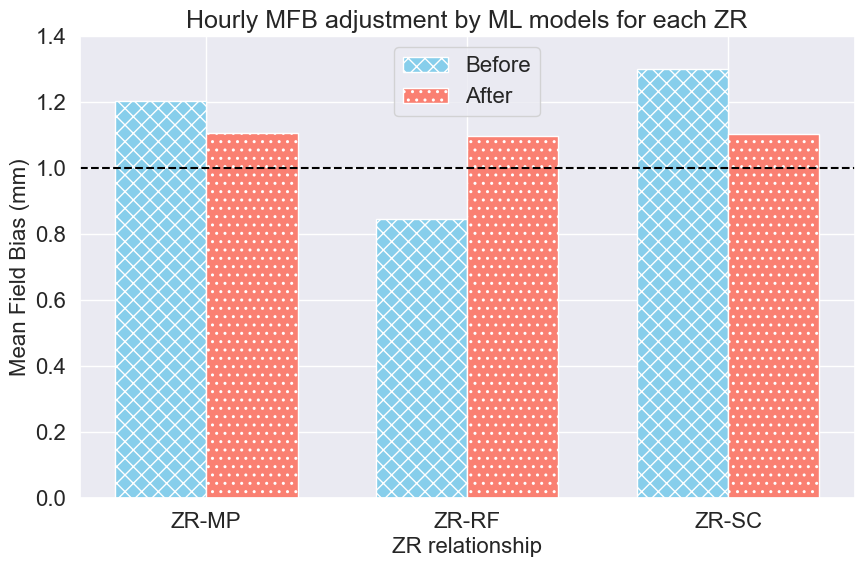

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Data
values = np.array([[before_adjust_MP, after_adjust_MP], 
                   [before_adjust_RF, after_adjust_RF], 
                   [before_adjust_SC, after_adjust_SC]])
labels = ['ZR-MP', 'ZR-RF', 'ZR-SC']
before_values = values[:, 0]
after_values = values[:, 1]

# Enlarge the figure plot
plt.figure(figsize=(10, 6))  

# Plot
bar_width = 0.35
index = np.arange(len(labels))
plt.bar(index, before_values, bar_width, label='Before', color='skyblue',hatch='xx')  
plt.bar(index + bar_width, after_values, bar_width, label='After', color='salmon',hatch='..')  

plt.ylim(0, 1.4)
plt.axhline(y=1.0, color='black', linestyle='--')

plt.xlabel('ZR relationship', fontsize=16)  
plt.ylabel('Mean Field Bias (mm)', fontsize=16) 
plt.title('Hourly MFB adjustment by ML models for each ZR', fontsize=18)  
plt.xticks(index + bar_width / 2, labels, fontsize=16)  
plt.yticks(fontsize=16) 
plt.legend(fontsize=16)  

plt.show()



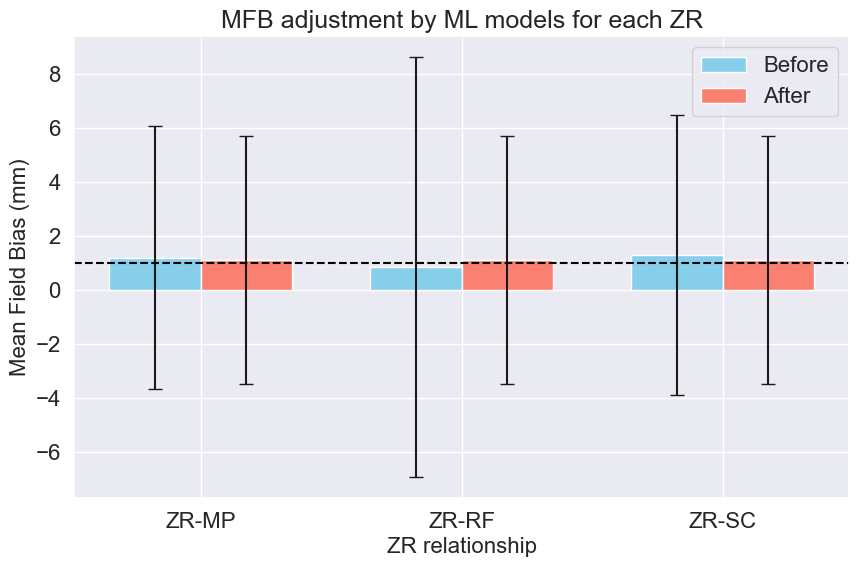

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Data
values = np.array([[before_adjust_MP, after_adjust_MP], 
                   [before_adjust_RF, after_adjust_RF], 
                   [before_adjust_SC, after_adjust_SC]])
std_error_bar = np.array([[std_before_adjust_MP, std_after_adjust_MP], 
                          [std_before_adjust_RF, std_after_adjust_RF], 
                          [std_before_adjust_SC, std_after_adjust_SC]])
labels = ['ZR-MP', 'ZR-RF', 'ZR-SC']
before_values = values[:, 0]
after_values = values[:, 1]
std_before_values = std_error_bar[:, 0]
std_after_values = std_error_bar[:, 1]

# Enlarge the figure plot
plt.figure(figsize=(10, 6))  

# Plot
bar_width = 0.35
index = np.arange(len(labels))
plt.bar(index, before_values, bar_width, yerr=std_before_values, capsize=5, label='Before', color='skyblue')  
plt.bar(index + bar_width, after_values, bar_width, yerr=std_after_values, capsize=5, label='After', color='salmon')  

plt.axhline(y=1.0, color='black', linestyle='--')

plt.xlabel('ZR relationship', fontsize=16)  
plt.ylabel('Mean Field Bias (mm)', fontsize=16) 
plt.title('MFB adjustment by ML models for each ZR', fontsize=18)  
plt.xticks(index + bar_width / 2, labels, fontsize=16)  
plt.yticks(fontsize=16) 
plt.legend(fontsize=16)  

plt.show()


In [23]:
np.mean(best_model_GradientBoostingRegressor.predict(X_test).flatten())

2.3110360310675815

In [24]:
np.std(best_model_GradientBoostingRegressor.predict(X_test).flatten())

2.1842553704112246

In [25]:
np.mean(X_test[:,1])

1.9611008924952964

In [26]:
np.std(X_test[:,1])

3.9722717690674427

In [27]:
np.mean(y_test.flatten()/X_test[:,1])

2.341622535108452

In [28]:
np.std(y_test.flatten()/X_test[:,1])

5.019050689135209

In [29]:
np.mean(y_test.flatten()/best_model_GradientBoostingRegressor.predict(X_test))

1.522907325909845

In [30]:
np.std(y_test.flatten()/best_model_GradientBoostingRegressor.predict(X_test))

9.24084334189894

In [31]:
y_test.flatten()- X_test[:,1]
after_adjust_SC=np.sum(y_test.flatten())/np.sum(best_model_GradientBoostingRegressor.predict(X_test).flatten())

In [32]:
before_adjust_SC=np.mean(y_test.flatten())-np.sum(X_test[:,1])
after_adjust_SC=np.sum(y_test.flatten())/np.sum(best_model_GradientBoostingRegressor.predict(X_test).flatten())